In [ ]:
%%capture
! pip install torchbnn==1.2.0
! pip install blitz-bayesian-pytorch

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
from blitz.modules import BayesianLinear
from blitz.losses import kl_divergence_from_nn

In [9]:
# Dataset Configuration
data_dir = r"C:\Users\User\Downloads\archive\Dataset_BUSI_with_GT"
image_size = (50, 50)  # Sesuai dengan ukuran patch dataset
batch_size = 32
num_classes = 2  # IDC positif (1) dan negatif (0)
num_epochs = 25
kl_weight = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Augmentation & Normalization
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Custom Dataset Class
class HistopathologyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# Load Dataset
image_paths = []
labels = []

data_subdirs = ['train', 'valid', 'test']
for subdir in data_subdirs:
    full_path = os.path.join(data_dir, subdir)
    if not os.path.exists(full_path):
        print(f"Warning: Directory {full_path} does not exist.")
        continue
    for root, _, files in os.walk(full_path):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                try:
                    label = 1 if "_class1" in file else 0  # Sesuaikan jika label beda format
                    image_paths.append(os.path.join(root, file))
                    labels.append(label)
                except ValueError:
                    print(f"Skipping invalid file: {file}")

if len(image_paths) == 0:
    raise ValueError("No image files found in the specified directory. Check the dataset path.")

# Split Dataset
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels if len(set(labels)) > 1 else None, random_state=42
)

train_dataset = HistopathologyDataset(train_paths, train_labels, transform)
val_dataset = HistopathologyDataset(val_paths, val_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

ValueError: No image files found in the specified directory. Check the dataset path.

In [4]:
print(len(train_dataset))
print(len(val_dataset))

2706
677


In [5]:
# Bayesian AlexNet
class BayesianAlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            BayesianLinear(256 * 6 * 6, 512), nn.ReLU(),
            nn.Dropout(0.5), BayesianLinear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Initialize Model
bayesian_model = BayesianAlexNet().to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bayesian_model.parameters(), lr=0.001)


In [6]:
# Training Function
def train_model(model, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels) + kl_weight * kl_divergence_from_nn(model)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += outputs.argmax(dim=1).eq(labels).sum().item()
        total += labels.size(0)
    return running_loss/len(train_loader), 100. * correct / total

# Training Loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(bayesian_model, optimizer)
    print(f"Epoch {epoch+1}: Accuracy: {train_acc:.2f}%")


Epoch 1: Accuracy: 99.30%
Epoch 2: Accuracy: 100.00%
Epoch 3: Accuracy: 100.00%


KeyboardInterrupt: 

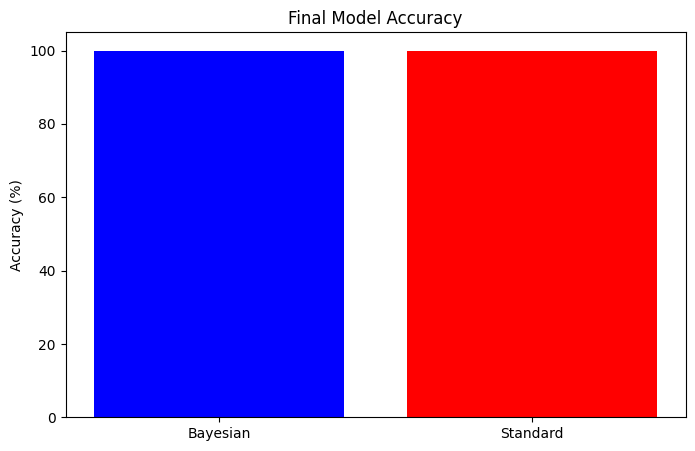

In [7]:
# Visualisasi Hasil Akhir
def plot_results(acc):
    plt.bar(['Bayesian'], [acc])
    plt.ylabel("Accuracy (%)")
    plt.title("Final Model Accuracy")
    plt.show()

plot_results(train_acc)